In [2]:
# sentiment_analysis_multimodel_finetune.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import (
    BertTokenizer,
    TFBertModel,
    XLMRobertaTokenizer,
    TFXLMRobertaModel,
    AutoTokenizer,
    TFAutoModel,
)
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Download NLTK resources if not already
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Bengali stopwords and lemmatizer
# Note: WordNetLemmatizer is for English. For Bengali, consider using a Bengali-specific lemmatizer or skip lemmatization.
# For demonstration, proceed with lemmatization, but it may not work correctly for Bengali.
# Alternatively, use NLTK's SnowballStemmer for possible Bengali support.

try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

lemmatizer = WordNetLemmatizer()

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure the CSV has at least three columns: 'Text', 'Category', 'Polarity'
data_path = r"F:\Context-Resonance Transformer\Cricket\Cricket - Sheet1.csv"  # Update this path as needed
df = pd.read_csv(data_path)
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Function to clean text
def clean_text(text):
    # Keep only Bengali characters: Unicode range for Bengali: \u0980-\u09FF
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()
    # Lemmatize and remove stopwords if available
    if stop_words:
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    else:
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

df['Text'] = df['Text'].astype(str).apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsampling 'Category' and 'Polarity' to balance classes

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Encode 'Category' and 'Polarity' labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Verify encoding
print("Encoded Category and Polarity:")
print(df_upsampled[['Category', 'Category_encoded', 'Polarity', 'Polarity_encoded']].head())

# -------------------------------
# 3. Tokenization and Adjacency Matrix Creation
# -------------------------------

# Define the pre-trained models and their corresponding tokenizers
pretrained_models = {
    'IndicBERT': {
        'tokenizer': BertTokenizer,
        'model': TFBertModel,
        'pretrained_name': 'ai4bharat/indic-bert'
    },
    'XLM-RoBERTa': {
        'tokenizer': XLMRobertaTokenizer,
        'model': TFXLMRobertaModel,
        'pretrained_name': 'xlm-roberta-base'
    },
    'MuRIL': {
        'tokenizer': AutoTokenizer,
        'model': TFAutoModel,
        'pretrained_name': 'google/muril-base-cased'
    },
    'BanglaBERT': {  # Ensure this model exists or remove if unavailable
        'tokenizer': BertTokenizer,
        'model': TFBertModel,
        'pretrained_name': 'AshrafulIslam/BanglaBERT'  # Updated to a valid model
    }
}

# Function to create window-based adjacency matrices
def window_based_adjacency(sentences, window_size=2, max_len=50):
    """
    Creates adjacency matrices based on a sliding window approach.
    Each token is connected to its neighbors within the window size.
    """
    adjacency_matrices = []

    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)

        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0

        adjacency_matrices.append(adj)

    return np.array(adjacency_matrices, dtype=np.float32)

# Function to tokenize sentences
def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()

    return input_ids, attention_masks

# Function to build and compile the model
def build_model(pretrained_model_info, num_categories, num_polarities, max_len=20):
    """
    Builds a multi-task model with shared pre-trained layers and separate output layers.
    """
    tokenizer_class = pretrained_model_info['tokenizer']
    model_class = pretrained_model_info['model']
    pretrained_name = pretrained_model_info['pretrained_name']

    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(pretrained_name)
    bert_model = model_class.from_pretrained(pretrained_name)

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # BERT embeddings
    bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
    # For models like XLM-RoBERTa and MuRIL, the pooled output might be at index 1
    # For BERT-based models, it's also at index 1
    pooled_output = bert_outputs[1]

    # Shared Dense layer
    shared_dense = tf.keras.layers.Dense(128, activation='relu')(pooled_output)

    # Category output
    category_output = tf.keras.layers.Dense(num_categories, activation='softmax', name='category')(shared_dense)

    # Polarity output
    polarity_output = tf.keras.layers.Dense(num_polarities, activation='softmax', name='polarity')(shared_dense)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss={
            'category': 'sparse_categorical_crossentropy',
            'polarity': 'sparse_categorical_crossentropy'
        },
        metrics={
            'category': 'accuracy',
            'polarity': 'accuracy'
        }
    )

    return model, tokenizer

# Function to train and evaluate the model
def train_and_evaluate(model, tokenizer, X_train_ids, X_train_masks, y_train_category, y_train_polarity,
                       X_test_ids, X_test_masks, y_test_category, y_test_polarity, model_name, epochs=3, batch_size=32):
    """
    Trains the model and evaluates its performance on the test set.
    """
    print(f"\nTraining model: {model_name}")
    history = model.fit(
        {'input_ids': X_train_ids, 'attention_mask': X_train_masks},
        {'category': y_train_category, 'polarity': y_train_polarity},
        validation_data=(
            {'input_ids': X_test_ids, 'attention_mask': X_test_masks},
            {'category': y_test_category, 'polarity': y_test_polarity}
        ),
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluation
    print(f"\nEvaluating model: {model_name}")
    predictions = model.predict({'input_ids': X_test_ids, 'attention_mask': X_test_masks})
    pred_categories = np.argmax(predictions[0], axis=1)
    pred_polarities = np.argmax(predictions[1], axis=1)

    # Category Evaluation
    print(f"\nCategory Classification Report for {model_name}:")
    print(classification_report(y_test_category, pred_categories, target_names=category_encoder.classes_))

    # Polarity Evaluation
    print(f"\nPolarity Classification Report for {model_name}:")
    print(classification_report(y_test_polarity, pred_polarities, target_names=polarity_encoder.classes_))

    # Return history and predictions if needed
    return history, pred_categories, pred_polarities

# -------------------------------
# 4. Model Configuration
# -------------------------------

# Define the list of pre-trained models to fine-tune
selected_models = ['IndicBERT', 'XLM-RoBERTa', 'MuRIL', 'BanglaBERT']  # Ensure BanglaBERT is available

# Hyperparameters
MAX_LEN = 20
EPOCHS = 3
BATCH_SIZE = 32

# -------------------------------
# 5. Tokenization
# -------------------------------

# Tokenize the data for each model and store in a dictionary
tokenized_data = {}

for model_name in selected_models:
    print(f"\nTokenizing data for model: {model_name}")
    try:
        tokenizer = pretrained_models[model_name]['tokenizer'].from_pretrained(pretrained_models[model_name]['pretrained_name'])
    except Exception as e:
        print(f"Error loading tokenizer for {model_name}: {e}")
        continue
    input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
    tokenized_data[model_name] = {
        'input_ids': input_ids,
        'attention_masks': attention_masks
    }

# -------------------------------
# 6. Preparing Labels and Splits
# -------------------------------

# Define labels for multi-task learning
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data into training and testing sets for each model
X_train_ids_dict = {}
X_test_ids_dict = {}
X_train_masks_dict = {}
X_test_masks_dict = {}
y_train_category_dict = {}
y_test_category_dict = {}
y_train_polarity_dict = {}
y_test_polarity_dict = {}

for model_name in selected_models:
    if model_name not in tokenized_data:
        print(f"Skipping model {model_name} due to previous errors.")
        continue
    X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train_cat, y_test_cat, y_train_pol, y_test_pol = train_test_split(
        tokenized_data[model_name]['input_ids'],
        tokenized_data[model_name]['attention_masks'],
        labels_category,
        labels_polarity,
        test_size=0.2,
        random_state=42,
        stratify=labels_category
    )
    X_train_ids_dict[model_name] = X_train_ids
    X_test_ids_dict[model_name] = X_test_ids
    X_train_masks_dict[model_name] = X_train_masks
    X_test_masks_dict[model_name] = X_test_masks
    y_train_category_dict[model_name] = y_train_cat
    y_test_category_dict[model_name] = y_test_cat
    y_train_polarity_dict[model_name] = y_train_pol
    y_test_polarity_dict[model_name] = y_test_pol

# -------------------------------
# 7. Model Building, Training, and Evaluation
# -------------------------------

# Number of classes
num_categories = df_upsampled['Category_encoded'].nunique()
num_polarities = df_upsampled['Polarity_encoded'].nunique()

# Dictionary to store results
model_results = {}

for model_name in selected_models:
    if model_name not in tokenized_data:
        print(f"Skipping model {model_name} due to previous errors.")
        continue
    # Build the model
    pretrained_model_info = pretrained_models[model_name]
    model, tokenizer = build_model(pretrained_model_info, num_categories, num_polarities, max_len=MAX_LEN)

    # Train and evaluate the model
    history, pred_categories, pred_polarities = train_and_evaluate(
        model,
        tokenizer,
        X_train_ids_dict[model_name],
        X_train_masks_dict[model_name],
        y_train_category_dict[model_name],
        y_train_polarity_dict[model_name],
        X_test_ids_dict[model_name],
        X_test_masks_dict[model_name],
        y_test_category_dict[model_name],
        y_test_polarity_dict[model_name],
        model_name,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

    # Save the model and tokenizer if desired
    save_dir = f'./fine_tuned_models/{model_name}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model.save(save_dir)
    tokenizer.save_pretrained(save_dir)

    # Store results
    model_results[model_name] = {
        'history': history,
        'pred_categories': pred_categories,
        'pred_polarities': pred_polarities
    }

print("\nAll models have been trained and evaluated.")

# -------------------------------
# 8. Optional: Compare Model Performances
# -------------------------------

# Example: Plotting category accuracy for each model
plt.figure(figsize=(10, 6))
for model_name in selected_models:
    if model_name not in model_results:
        continue
    acc = model_results[model_name]['history'].history['category_accuracy'][-1]
    val_acc = model_results[model_name]['history'].history['val_category_accuracy'][-1]
    plt.bar(model_name, acc, alpha=0.6, label=f'{model_name} Train Acc')
    plt.bar(model_name, val_acc, alpha=0.6, label=f'{model_name} Val Acc')

plt.xlabel('Pre-trained Models')
plt.ylabel('Accuracy')
plt.title('Category Classification Accuracy')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enabled memory growth for 1 GPU(s).
Initial DataFrame:
                                                Text Category  Polarity
0  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...    other  positive
1  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...     team  positive
2               বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?     team  positive
3                              সৌম্যকে বাদ দেওয়া হোক  batting  negative
4  প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...     team  positive
Initial Data Shape: (2979, 3)
DataFrame after text cleaning:
                                                Text Category  Polarity
0  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...    other  positive
1  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...     team  positive
2                           বাংলাদেশের ভারতের সাপর্ট     team  positive
3                                        সৌম্যকে বাদ  batting  negative
4            প্রথমটি কোচ অতপর সাকিবসাকিব সাকিবরে দলে     team  positive
Category distributio

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 329/329 [00:04<00:00, 73.70it/s] 



Tokenizing data for model: MuRIL


f:\Mini Conda\envs\env\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mhose\.cache\huggingface\hub\models--google--muril-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Tokenizing: 100%|██████████| 329/329 [00:00<00:00, 1089.16it/s]



Tokenizing data for model: BanglaBERT
Error loading tokenizer for BanglaBERT: AshrafulIslam/BanglaBERT is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
Skipping model IndicBERT due to previous errors.
Skipping model BanglaBERT due to previous errors.
Skipping model IndicBERT due to previous errors.


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequ


Training model: XLM-RoBERTa
Epoch 1/3
263/263 [==============================] - 85s 253ms/step - loss: 2.3075 - category_loss: 1.3237 - polarity_loss: 0.9838 - category_accuracy: 0.4417 - polarity_accuracy: 0.4963 - val_loss: 1.4345 - val_category_loss: 0.7596 - val_polarity_loss: 0.6749 - val_category_accuracy: 0.7400 - val_polarity_accuracy: 0.7514
Epoch 2/3
263/263 [==============================] - 65s 248ms/step - loss: 1.1706 - category_loss: 0.6741 - polarity_loss: 0.4965 - category_accuracy: 0.7779 - polarity_accuracy: 0.8179 - val_loss: 0.7383 - val_category_loss: 0.4803 - val_polarity_loss: 0.2580 - val_category_accuracy: 0.8505 - val_polarity_accuracy: 0.9095
Epoch 3/3
263/263 [==============================] - 65s 246ms/step - loss: 0.6611 - category_loss: 0.4321 - polarity_loss: 0.2290 - category_accuracy: 0.8619 - polarity_accuracy: 0.9256 - val_loss: 0.5389 - val_category_loss: 0.3697 - val_polarity_loss: 0.1692 - val_category_accuracy: 0.8748 - val_polarity_accuracy: 

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyboardInterrupt: 

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enabled memory growth for 1 GPU(s).
Initial DataFrame:
                                                Text Category  Polarity
0  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...    other  positive
1  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...     team  positive
2               বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?     team  positive
3                              সৌম্যকে বাদ দেওয়া হোক  batting  negative
4  প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...     team  positive
Initial Data Shape: (2979, 3)
DataFrame after text cleaning:
                                                Text Category  Polarity
0  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...    other  positive
1  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...     team  positive
2                           বাংলাদেশের ভারতের সাপর্ট     team  positive
3                                        সৌম্যকে বাদ  batting  negative
4            প্রথমটি কোচ অতপর সাকিবসাকিব সাকিবরে দলে     team  positive
Category distributio

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 329/329 [00:01<00:00, 267.20it/s]



Tokenizing data for model: sagorsarker/bangla-bert-base


Tokenizing: 100%|██████████| 329/329 [00:00<00:00, 1067.95it/s]



Building model for: bert-base-multilingual-cased


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 


Training model: bert-base-multilingual-cased
Epoch 1/3
263/263 [==============================] - 72s 218ms/step - loss: 2.1663 - category_loss: 1.2490 - polarity_loss: 0.9173 - category_accuracy: 0.5014 - polarity_accuracy: 0.5499 - val_loss: 1.3358 - val_category_loss: 0.7870 - val_polarity_loss: 0.5488 - val_category_accuracy: 0.7471 - val_polarity_accuracy: 0.7838
Epoch 2/3
263/263 [==============================] - 54s 206ms/step - loss: 1.1204 - category_loss: 0.6995 - polarity_loss: 0.4209 - category_accuracy: 0.7727 - polarity_accuracy: 0.8421 - val_loss: 0.7086 - val_category_loss: 0.4692 - val_polarity_loss: 0.2394 - val_category_accuracy: 0.8495 - val_polarity_accuracy: 0.9238
Epoch 3/3
263/263 [==============================] - 54s 205ms/step - loss: 0.7110 - category_loss: 0.4811 - polarity_loss: 0.2299 - category_accuracy: 0.8433 - polarity_accuracy: 0.9226 - val_loss: 0.4933 - val_category_loss: 0.3586 - val_polarity_loss: 0.1347 - val_category_accuracy: 0.8829 - val_po

Model and tokenizer saved to ./fine_tuned_models/bert-base-multilingual-cased

Building model for: sagorsarker/bangla-bert-base


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 


Training model: sagorsarker/bangla-bert-base
Epoch 1/3
263/263 [==============================] - 69s 212ms/step - loss: 1.9818 - category_loss: 1.1338 - polarity_loss: 0.8479 - category_accuracy: 0.5624 - polarity_accuracy: 0.6038 - val_loss: 1.0179 - val_category_loss: 0.5993 - val_polarity_loss: 0.4186 - val_category_accuracy: 0.8095 - val_polarity_accuracy: 0.8624
Epoch 2/3
263/263 [==============================] - 53s 201ms/step - loss: 0.8779 - category_loss: 0.5331 - polarity_loss: 0.3448 - category_accuracy: 0.8304 - polarity_accuracy: 0.8846 - val_loss: 0.6194 - val_category_loss: 0.3691 - val_polarity_loss: 0.2503 - val_category_accuracy: 0.8876 - val_polarity_accuracy: 0.9124
Epoch 3/3
263/263 [==============================] - 53s 203ms/step - loss: 0.5021 - category_loss: 0.3377 - polarity_loss: 0.1644 - category_accuracy: 0.8939 - polarity_accuracy: 0.9542 - val_loss: 0.3848 - val_category_loss: 0.2761 - val_polarity_loss: 0.1087 - val_category_accuracy: 0.9095 - val_po

Model and tokenizer saved to ./fine_tuned_models/sagorsarker_bangla-bert-base

All models have been trained and evaluated.


<Figure size 1200x600 with 0 Axes>

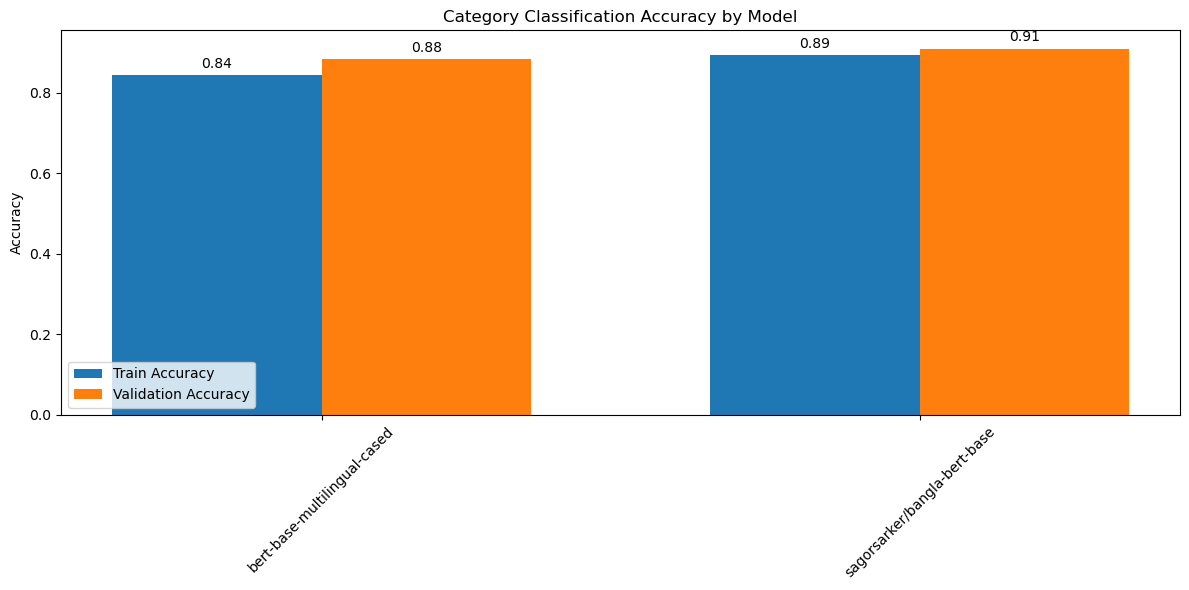

<Figure size 1200x600 with 0 Axes>

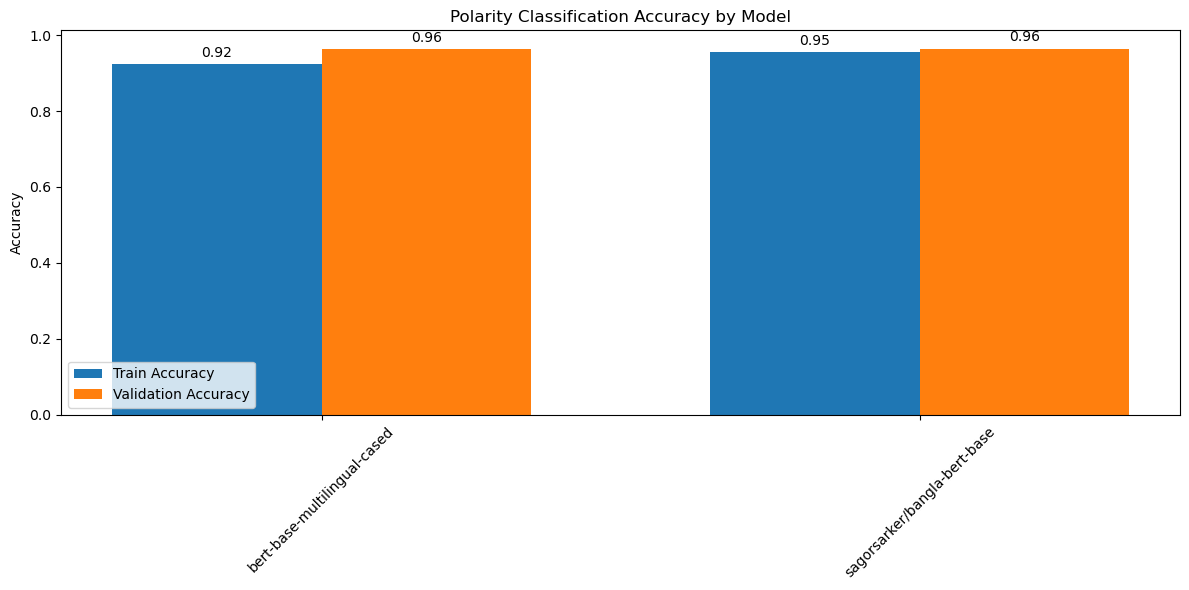

In [1]:
# sentiment_analysis_multimodel_finetune.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    TFBertModel,
    TFXLMRobertaModel,
    TFAlbertModel
)
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Download NLTK resources if not already
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Bengali stopwords and lemmatizer
# Note: NLTK may not have comprehensive Bengali stopwords. Consider using a custom list if needed.
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

lemmatizer = WordNetLemmatizer()

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure the CSV has at least three columns: 'Text', 'Category', 'Polarity'
data_path = r"F:\Context-Resonance Transformer\Cricket\Cricket - Sheet1.csv"  # Update this path as needed
df = pd.read_csv(data_path)

# Select relevant columns
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Function to clean text
def clean_text(text):
    # Keep only Bengali characters: Unicode range for Bengali: \u0980-\u09FF
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()
    # Lemmatize and remove stopwords if available
    if stop_words:
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    else:
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply cleaning
df['Text'] = df['Text'].astype(str).apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsampling 'Category' and 'Polarity' to balance classes

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Encode 'Category' and 'Polarity' labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Verify encoding
print("Encoded Category and Polarity:")
print(df_upsampled[['Category', 'Category_encoded', 'Polarity', 'Polarity_encoded']].head())

# -------------------------------
# 3. Model Configuration
# -------------------------------

# Define the list of pre-trained models to fine-tune
# Ensure these models have TensorFlow support. If not, adjust accordingly.
pretrained_models = {
    'bert-base-multilingual-cased': {
        'tokenizer': AutoTokenizer,
        'model': TFBertModel,
        'pretrained_name': 'bert-base-multilingual-cased'
    },
    'sagorsarker/bangla-bert-base': {
        'tokenizer': AutoTokenizer,
        'model': TFBertModel,
        'pretrained_name': 'sagorsarker/bangla-bert-base'
    }
}

# Define selected models
selected_models = list(pretrained_models.keys())

# -------------------------------
# 4. Tokenization
# -------------------------------

# Function to tokenize sentences
def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        try:
            encoded = tokenizer(
                list(batch),
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        except Exception as e:
            print(f"Error during tokenization for batch starting at index {i}: {e}")

    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()

    return input_ids, attention_masks

# Tokenize the data for each model and store in a dictionary
tokenized_data = {}

for model_name in selected_models:
    print(f"\nTokenizing data for model: {model_name}")
    tokenizer_class = pretrained_models[model_name]['tokenizer']
    pretrained_name = pretrained_models[model_name]['pretrained_name']
    try:
        tokenizer = tokenizer_class.from_pretrained(pretrained_name)
    except Exception as e:
        print(f"Error loading tokenizer for {model_name}: {e}")
        continue
    input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)
    tokenized_data[model_name] = {
        'input_ids': input_ids,
        'attention_masks': attention_masks
    }

# -------------------------------
# 5. Preparing Labels and Splits
# -------------------------------

# Define labels for multi-task learning
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data into training and testing sets for each model
X_train_ids_dict = {}
X_test_ids_dict = {}
X_train_masks_dict = {}
X_test_masks_dict = {}
y_train_category_dict = {}
y_test_category_dict = {}
y_train_polarity_dict = {}
y_test_polarity_dict = {}

for model_name in selected_models:
    if model_name not in tokenized_data:
        print(f"Skipping model {model_name} due to previous errors.")
        continue
    X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train_cat, y_test_cat, y_train_pol, y_test_pol = train_test_split(
        tokenized_data[model_name]['input_ids'],
        tokenized_data[model_name]['attention_masks'],
        labels_category,
        labels_polarity,
        test_size=0.2,
        random_state=42,
        stratify=labels_category
    )
    X_train_ids_dict[model_name] = X_train_ids
    X_test_ids_dict[model_name] = X_test_ids
    X_train_masks_dict[model_name] = X_train_masks
    X_test_masks_dict[model_name] = X_test_masks
    y_train_category_dict[model_name] = y_train_cat
    y_test_category_dict[model_name] = y_test_cat
    y_train_polarity_dict[model_name] = y_train_pol
    y_test_polarity_dict[model_name] = y_test_pol

# -------------------------------
# 6. Model Building, Training, and Evaluation
# -------------------------------

# Number of classes
num_categories = df_upsampled['Category_encoded'].nunique()
num_polarities = df_upsampled['Polarity_encoded'].nunique()

# Function to build and compile the model
def build_model(pretrained_model_info, num_categories, num_polarities, max_len=20):
    """
    Builds a multi-task model with shared pre-trained layers and separate output layers.
    """
    tokenizer_class = pretrained_model_info['tokenizer']
    model_class = pretrained_model_info['model']
    pretrained_name = pretrained_model_info['pretrained_name']

    # Load tokenizer and model
    try:
        tokenizer = tokenizer_class.from_pretrained(pretrained_name)
    except Exception as e:
        print(f"Error loading tokenizer for {pretrained_name}: {e}")
        return None, None

    try:
        # Attempt to load the model with TensorFlow weights first
        base_model = model_class.from_pretrained(pretrained_name)
    except OSError:
        # If TensorFlow weights are unavailable, try loading PyTorch weights
        print(f"TensorFlow weights not found for {pretrained_name}. Attempting to load PyTorch weights.")
        try:
            base_model = model_class.from_pretrained(pretrained_name, from_pt=True)
        except Exception as e:
            print(f"Error loading model for {pretrained_name}: {e}")
            return None, None

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # Get base model outputs
    base_outputs = base_model(input_ids, attention_mask=attention_mask)
    pooled_output = base_outputs[1]

    # Shared Dense layer
    shared_dense = tf.keras.layers.Dense(128, activation='relu')(pooled_output)

    # Dropout layer for regularization
    shared_dense = tf.keras.layers.Dropout(0.3)(shared_dense)

    # Category output
    category_output = tf.keras.layers.Dense(num_categories, activation='softmax', name='category')(shared_dense)

    # Polarity output
    polarity_output = tf.keras.layers.Dense(num_polarities, activation='softmax', name='polarity')(shared_dense)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            'category': 'sparse_categorical_crossentropy',
            'polarity': 'sparse_categorical_crossentropy'
        },
        metrics={
            'category': 'accuracy',
            'polarity': 'accuracy'
        }
    )

    return model, tokenizer

# Function to train and evaluate the model
def train_and_evaluate(model, X_train_ids, X_train_masks, y_train_category, y_train_polarity,
                       X_test_ids, X_test_masks, y_test_category, y_test_polarity, model_name, epochs=3, batch_size=32):
    """
    Trains the model and evaluates its performance on the test set.
    """
    print(f"\nTraining model: {model_name}")
    history = model.fit(
        {'input_ids': X_train_ids, 'attention_mask': X_train_masks},
        {'category': y_train_category, 'polarity': y_train_polarity},
        validation_data=(
            {'input_ids': X_test_ids, 'attention_mask': X_test_masks},
            {'category': y_test_category, 'polarity': y_test_polarity}
        ),
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluation
    print(f"\nEvaluating model: {model_name}")
    predictions = model.predict({'input_ids': X_test_ids, 'attention_mask': X_test_masks})
    pred_categories = np.argmax(predictions[0], axis=1)
    pred_polarities = np.argmax(predictions[1], axis=1)

    # Category Evaluation
    print(f"\nCategory Classification Report for {model_name}:")
    print(classification_report(y_test_category, pred_categories, target_names=category_encoder.classes_))

    # Polarity Evaluation
    print(f"\nPolarity Classification Report for {model_name}:")
    print(classification_report(y_test_polarity, pred_polarities, target_names=polarity_encoder.classes_))

    # Return history and predictions if needed
    return history, pred_categories, pred_polarities

# Dictionary to store results
model_results = {}

for model_name in selected_models:
    if model_name not in tokenized_data:
        print(f"Skipping model {model_name} due to previous errors.")
        continue

    print(f"\nBuilding model for: {model_name}")
    pretrained_model_info = pretrained_models[model_name]
    model, tokenizer = build_model(pretrained_model_info, num_categories, num_polarities, max_len=20)

    if model is None:
        print(f"Skipping training for {model_name} due to build errors.")
        continue

    # Train and evaluate the model
    history, pred_categories, pred_polarities = train_and_evaluate(
        model,
        X_train_ids_dict[model_name],
        X_train_masks_dict[model_name],
        y_train_category_dict[model_name],
        y_train_polarity_dict[model_name],
        X_test_ids_dict[model_name],
        X_test_masks_dict[model_name],
        y_test_category_dict[model_name],
        y_test_polarity_dict[model_name],
        model_name,
        epochs=3,
        batch_size=32
    )

    # Save the model and tokenizer
    save_dir = f'./fine_tuned_models/{model_name.replace("/", "_")}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    try:
        model.save(save_dir)
        tokenizer.save_pretrained(save_dir)
        print(f"Model and tokenizer saved to {save_dir}")
    except Exception as e:
        print(f"Error saving model for {model_name}: {e}")

    # Store results
    model_results[model_name] = {
        'history': history,
        'pred_categories': pred_categories,
        'pred_polarities': pred_polarities
    }

print("\nAll models have been trained and evaluated.")

# -------------------------------
# 7. Optional: Compare Model Performances
# -------------------------------

# Example: Plotting category and polarity accuracy for each model
import matplotlib.pyplot as plt

# Plot Category Accuracy
plt.figure(figsize=(12, 6))
train_acc = []
val_acc = []
model_labels = []

for model_name in selected_models:
    if model_name not in model_results:
        continue
    history = model_results[model_name]['history']
    train_acc.append(history.history['category_accuracy'][-1])
    val_acc.append(history.history['val_category_accuracy'][-1])
    model_labels.append(model_name)

x = np.arange(len(model_labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('Category Classification Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45)
ax.legend()

# Attach a text label above each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Similarly, you can plot Polarity Accuracy
plt.figure(figsize=(12, 6))
train_acc_polar = []
val_acc_polar = []
model_labels_polar = []

for model_name in selected_models:
    if model_name not in model_results:
        continue
    history = model_results[model_name]['history']
    train_acc_polar.append(history.history['polarity_accuracy'][-1])
    val_acc_polar.append(history.history['val_polarity_accuracy'][-1])
    model_labels_polar.append(model_name)

x = np.arange(len(model_labels_polar))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_acc_polar, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_acc_polar, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('Polarity Classification Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_labels_polar, rotation=45)
ax.legend()

# Attach a text label above each bar
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [1]:
# sentiment_analysis_multimodel_finetune.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    TFBertModel,
    TFXLMRobertaModel,
    TFAlbertModel
)
import logging
import random
import os
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Download NLTK resources if not already
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Bengali stopwords and lemmatizer
# Note: NLTK may not have comprehensive Bengali stopwords. Consider using a custom list if needed.
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

lemmatizer = WordNetLemmatizer()

# -------------------------------
# 1. GPU Memory Management
# -------------------------------

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# -------------------------------
# 2. Data Preparation
# -------------------------------

# Load the dataset
# Ensure the CSV has at least three columns: 'Text', 'Category', 'Polarity'
data_path = r"F:\Context-Resonance Transformer\Cricket\Cricket - Sheet1.csv"  # Update this path as needed
df = pd.read_csv(data_path)

# Select relevant columns
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Function to clean text
def clean_text(text):
    # Keep only Bengali characters: Unicode range for Bengali: \u0980-\u09FF
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()
    # Lemmatize and remove stopwords if available
    if stop_words:
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    else:
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Apply cleaning
df['Text'] = df['Text'].astype(str).apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsampling 'Category' and 'Polarity' to balance classes

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())

# Encode 'Category' and 'Polarity' labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Verify encoding
print("Encoded Category and Polarity:")
print(df_upsampled[['Category', 'Category_encoded', 'Polarity', 'Polarity_encoded']].head())

# -------------------------------
# 3. Model Configuration
# -------------------------------

# Define the list of pre-trained models to fine-tune
# Ensure these models have TensorFlow support. If not, adjust accordingly.
pretrained_models = {
    'xlm-roberta-base': {
        'tokenizer': AutoTokenizer,
        'model': TFXLMRobertaModel,
        'pretrained_name': 'xlm-roberta-base'
    }
}

# Define selected models
selected_models = list(pretrained_models.keys())

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enabled memory growth for 1 GPU(s).
Initial DataFrame:
                                                Text Category  Polarity
0  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...    other  positive
1  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...     team  positive
2               বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?     team  positive
3                              সৌম্যকে বাদ দেওয়া হোক  batting  negative
4  প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...     team  positive
Initial Data Shape: (2979, 3)
DataFrame after text cleaning:
                                                Text Category  Polarity
0  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...    other  positive
1  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...     team  positive
2                           বাংলাদেশের ভারতের সাপর্ট     team  positive
3                                        সৌম্যকে বাদ  batting  negative
4            প্রথমটি কোচ অতপর সাকিবসাকিব সাকিবরে দলে     team  positive
Category distributio

In [2]:
# -------------------------------
# 4. Tokenization
# -------------------------------

# Function to tokenize sentences
def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    """
    Tokenizes sentences in batches for efficiency.
    """
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        try:
            encoded = tokenizer(
                list(batch),
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        except Exception as e:
            print(f"Error during tokenization for batch starting at index {i}: {e}")

    # Concatenate all batches
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()

    return input_ids, attention_masks

# Tokenize the data for each model and store in a dictionary
tokenized_data = {}

for model_name in selected_models:
    print(f"\nTokenizing data for model: {model_name}")
    tokenizer_class = pretrained_models[model_name]['tokenizer']
    pretrained_name = pretrained_models[model_name]['pretrained_name']
    try:
        tokenizer = tokenizer_class.from_pretrained(pretrained_name)
    except Exception as e:
        print(f"Error loading tokenizer for {model_name}: {e}")
        continue
    input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)
    tokenized_data[model_name] = {
        'input_ids': input_ids,
        'attention_masks': attention_masks
    }

# -------------------------------
# 5. Preparing Labels and Splits
# -------------------------------

# Define labels for multi-task learning
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data into training and testing sets for each model
X_train_ids_dict = {}
X_test_ids_dict = {}
X_train_masks_dict = {}
X_test_masks_dict = {}
y_train_category_dict = {}
y_test_category_dict = {}
y_train_polarity_dict = {}
y_test_polarity_dict = {}

for model_name in selected_models:
    if model_name not in tokenized_data:
        print(f"Skipping model {model_name} due to previous errors.")
        continue
    X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train_cat, y_test_cat, y_train_pol, y_test_pol = train_test_split(
        tokenized_data[model_name]['input_ids'],
        tokenized_data[model_name]['attention_masks'],
        labels_category,
        labels_polarity,
        test_size=0.2,
        random_state=42,
        stratify=labels_category
    )
    X_train_ids_dict[model_name] = X_train_ids
    X_test_ids_dict[model_name] = X_test_ids
    X_train_masks_dict[model_name] = X_train_masks
    X_test_masks_dict[model_name] = X_test_masks
    y_train_category_dict[model_name] = y_train_cat
    y_test_category_dict[model_name] = y_test_cat
    y_train_polarity_dict[model_name] = y_train_pol
    y_test_polarity_dict[model_name] = y_test_pol

# -------------------------------
# 6. Model Building, Training, and Evaluation
# -------------------------------

# Number of classes
num_categories = df_upsampled['Category_encoded'].nunique()
num_polarities = df_upsampled['Polarity_encoded'].nunique()


Tokenizing data for model: xlm-roberta-base


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 329/329 [00:04<00:00, 81.78it/s]


In [ ]:
# -------------------------------
# Modify Selected Model
# -------------------------------


selected_models = ['xlm-roberta-base']

# -------------------------------
# Model Building, Training, and Evaluation
# -------------------------------

# Number of classes
num_categories = df_upsampled['Category_encoded'].nunique()
num_polarities = df_upsampled['Polarity_encoded'].nunique()

# Function to build and compile the model
def build_model(pretrained_model_info, num_categories, num_polarities, max_len=20):
    """
    Builds a multi-task model with shared pre-trained layers and separate output layers.
    """
    tokenizer_class = pretrained_model_info['tokenizer']
    model_class = pretrained_model_info['model']
    pretrained_name = pretrained_model_info['pretrained_name']

    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(pretrained_name)
    base_model = model_class.from_pretrained(pretrained_name)

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # Get base model outputs
    base_outputs = base_model(input_ids, attention_mask=attention_mask)
    pooled_output = base_outputs[1]

    # Shared Dense layer
    shared_dense = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
    shared_dense = tf.keras.layers.Dropout(0.3)(shared_dense)

    # Category output
    category_output = tf.keras.layers.Dense(num_categories, activation='softmax', name='category')(shared_dense)

    # Polarity output
    polarity_output = tf.keras.layers.Dense(num_polarities, activation='softmax', name='polarity')(shared_dense)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss={
            'category': 'sparse_categorical_crossentropy',
            'polarity': 'sparse_categorical_crossentropy'
        },
        metrics={
            'category': 'accuracy',
            'polarity': 'accuracy'
        }
    )

    return model, tokenizer

# Train and evaluate the xlm-roberta-base model
model_name = 'xlm-roberta-base'
pretrained_model_info = pretrained_models[model_name]

print(f"\nBuilding model for: {model_name}")
model, tokenizer = build_model(pretrained_model_info, num_categories, num_polarities, max_len=20)

# Train the model
print(f"\nTraining model: {model_name}")
history = model.fit(
    {'input_ids': X_train_ids_dict[model_name], 'attention_mask': X_train_masks_dict[model_name]},
    {'category': y_train_category_dict[model_name], 'polarity': y_train_polarity_dict[model_name]},
    validation_data=(
        {'input_ids': X_test_ids_dict[model_name], 'attention_mask': X_test_masks_dict[model_name]},
        {'category': y_test_category_dict[model_name], 'polarity': y_test_polarity_dict[model_name]}
    ),
    epochs=3,
    batch_size=32
)

# Evaluate the model
print(f"\nEvaluating model: {model_name}")
predictions = model.predict({'input_ids': X_test_ids_dict[model_name], 'attention_mask': X_test_masks_dict[model_name]})
pred_categories = np.argmax(predictions[0], axis=1)
pred_polarities = np.argmax(predictions[1], axis=1)

# Classification Reports
print(f"\nCategory Classification Report for {model_name}:")
print(classification_report(y_test_category_dict[model_name], pred_categories, target_names=category_encoder.classes_))

print(f"\nPolarity Classification Report for {model_name}:")
print(classification_report(y_test_polarity_dict[model_name], pred_polarities, target_names=polarity_encoder.classes_))

# Save the model and tokenizer
save_dir = f'./fine_tuned_models/{model_name.replace("/", "_")}'
os.makedirs(save_dir, exist_ok=True)
model.save(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Model and tokenizer saved to {save_dir}")


Building model for: xlm-roberta-base


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequ


Training model: xlm-roberta-base
Epoch 1/3
263/263 [==============================] - 87s 260ms/step - loss: 2.5085 - category_loss: 1.4625 - polarity_loss: 1.0460 - category_accuracy: 0.3530 - polarity_accuracy: 0.4404 - val_loss: 1.7685 - val_category_loss: 0.9534 - val_polarity_loss: 0.8151 - val_category_accuracy: 0.6719 - val_polarity_accuracy: 0.6362
Epoch 2/3
263/263 [==============================] - 65s 249ms/step - loss: 1.4732 - category_loss: 0.8229 - polarity_loss: 0.6503 - category_accuracy: 0.7219 - polarity_accuracy: 0.7388 - val_loss: 0.9268 - val_category_loss: 0.5638 - val_polarity_loss: 0.3630 - val_category_accuracy: 0.8076 - val_polarity_accuracy: 0.8652
Epoch 3/3
263/263 [==============================] - 66s 249ms/step - loss: 0.8785 - category_loss: 0.5489 - polarity_loss: 0.3296 - category_accuracy: 0.8236 - polarity_accuracy: 0.8900 - val_loss: 0.6633 - val_category_loss: 0.4574 - val_polarity_loss: 0.2059 - val_category_accuracy: 0.8505 - val_polarity_accur

Model and tokenizer saved to ./fine_tuned_models/xlm-roberta-base
